In [396]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import pandas_datareader as pdr

### Numerical example of how the spot curve and forward curve can be derived from a par curve

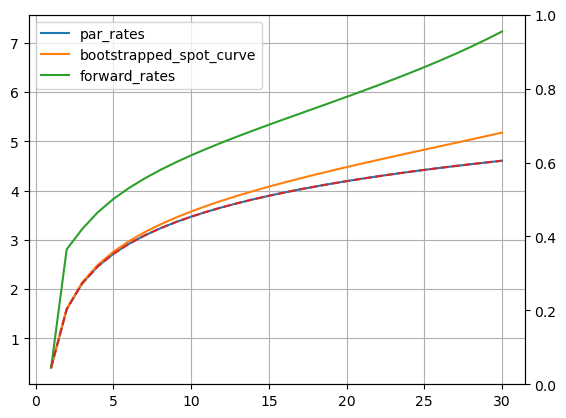

In [677]:
x = np.linspace(1.5,100,num=30)
y = np.log(x)

YC_df = pd.DataFrame(y, columns=['par_rates'], 
                     index=np.arange(1,len(y)+1))

def IR_bootstrapping(YC_df):
    for year in list(YC_df.index):
        if year == 1:
            YC_df['bootstrapped_spot_curve'] = (100*(1+YC_df.par_rates[1]/100) / 100 -1) * 100
            YC_df['bootstrapped_spot_DF'] = 1/(1+YC_df.par_rates[1]/100)
        elif year > 1:
            # spot rate bootstrapping process after Year 1
            # coupon based on par curve
            coupon = 100 * YC_df.par_rates[year]/100

            # discount factors using the past bootstrapped spot rates until period t-1
            prev_bootstrapped_DFs = YC_df['bootstrapped_spot_DF'][:year-1]

            # boostrapping spot rate in period t
            bootstrapped_spot_rate = 100 * (((100+coupon) / (100 - sum(coupon * prev_bootstrapped_DFs))) ** (1/year) - 1)

            # update period t boostrapped spot rate and discount factor
            YC_df.loc[year,'bootstrapped_spot_curve'] = bootstrapped_spot_rate
            YC_df.loc[year,'bootstrapped_spot_DF'] = 1/(1+YC_df.bootstrapped_spot_curve[year]/100) ** year
    return YC_df

YC_df = IR_bootstrapping(YC_df)

def forward_rates(YC_df):
    YC_df['year'] = YC_df.index
    longer_loan_rate = (1+YC_df.bootstrapped_spot_curve/100) ** YC_df.year
    shorter_loan_rate = (1+YC_df.bootstrapped_spot_curve.shift(1)/100) ** YC_df.year.shift(1)
    shorter_loan_rate[1] = 1
    YC_df['forward_rates'] = 100 * ((longer_loan_rate / shorter_loan_rate) -1)
    return YC_df

YC_df = forward_rates(YC_df)

# reverse engineer to get par rates
YC_df['par_rates_from_spotcurve'] = (1-YC_df.bootstrapped_spot_DF) / YC_df.bootstrapped_spot_DF.cumsum() * 100

# def swap_fixed_rates(YC_df, Nyear=10):
#     swap_rates = []
#     for year in list(YC_df.index):
#         if year == 1:
#             yr = year + (Nyear-1)
#             DFs = YC_df.bootstrapped_spot_DF[:yr]
#             SFR = 100 * (1 - DFs.iloc[-1]) / np.sum(DFs)
#             swap_rates.append(SFR)
#         else:
#             yr = year + (Nyear-1)
#             DFs = YC_df.bootstrapped_spot_DF[year-1:yr]
#             if len(DFs) < Nyear:
#                 swap_rates.append(0)
#                 continue
#             SFR = 100 * (1 - DFs.iloc[-1]) / np.sum(DFs)
#             swap_rates.append(SFR)
#     return swap_rates

# YC_df['swap_fixed_rates'] = swap_fixed_rates(YC_df, Nyear=15)
# YC_df['swap_fixed_rates'] = YC_df.swap_fixed_rates.replace({0:None})

fig,ax = plt.subplots()
ax1 = ax.twinx()
YC_df[['par_rates','bootstrapped_spot_curve','forward_rates']].plot(ax=ax)
YC_df['par_rates_from_spotcurve'].plot(linestyle='--', ax=ax);
ax.grid()
#YC_df['swap_fixed_rates'].plot(linestyle='--', ax=ax1);

### Binomial Interest Rate Tree Paths
can be used to value interest dertivatives: IR options, IR swaps, Bond with embedded options

Binomial interest rate paths: 512


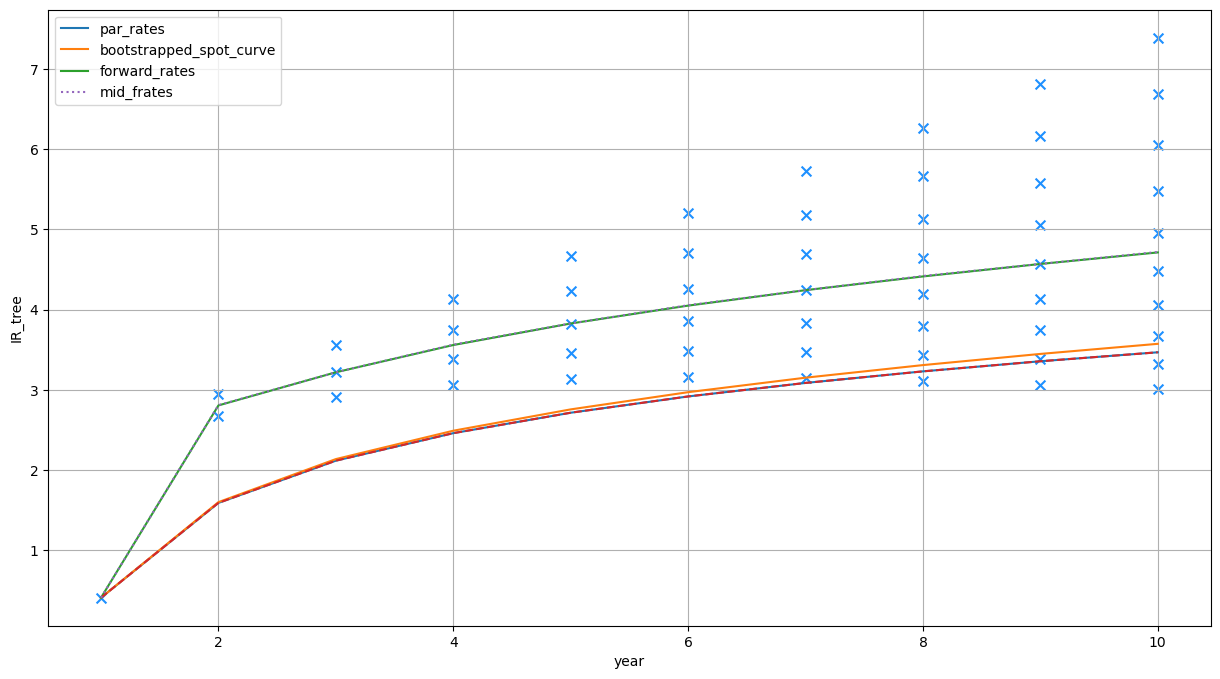

In [678]:
def generate_IR_tree(fcurve, maturity, IR_vol = 0.1): 
    # YC_df = yield curve df with forward_rates column for forward curve with years as index
    # maturity = Length of IR tree, maturity in years
    # IR_vol = Interest Rate volatility assumption
    
    N = len(fcurve[:maturity])
    S_1 = fcurve[1]
    paths = 2 ** (N-1)
    print('Binomial interest rate paths:', paths)
    
    #generate IR tree
    binomial_tree = np.zeros((N,N))
    # matrix to map exp(+2*sigma) distance between nodes in the same period
    adj_nodes = (np.zeros((N,N)) + np.arange(0,N,1))
    # mask upper triangle
    adj_nodes = adj_nodes * np.tril(np.ones_like(adj_nodes)) 
    # years matrix to provide time period index (in years) for each IR tree nodes
    years_mat = (np.zeros((N,N)) + np.arange(0,N,1).reshape(-1,1)) * np.tril(np.ones_like(adj_nodes))
    
    for period in range(len(binomial_tree)):
        # create the bottom IR path for the IR tree, top - bottom IR path for each period: * exp(2*(period-1)*sd) apart
        # bottom IR path = forward rate for the period * exp((-2*(period-1)*sd)/2)
        # period is to index the IR tree at each period
        year = period+1 
        frate_this_period = fcurve[year]
        binomial_tree[period] = frate_this_period/100 * np.exp((-2*(year-1)*IR_vol) / 2) * 100

    # adjust upper nodes for each period by * exp(-2* number of 2sigmas * sd)
    binomial_tree = binomial_tree * np.exp(2*(adj_nodes)*IR_vol) * np.tril(np.ones_like(adj_nodes))

    IR_tree = pd.DataFrame(binomial_tree.reshape(-1,1), index=(years_mat.reshape(1,-1)+1).tolist()).reset_index()
    IR_tree = IR_tree.set_axis(['year','IR_tree'], axis=1)
    IR_tree = IR_tree[~IR_tree.IR_tree.eq(0)]
    return IR_tree

def calculate_mid_frates(IR_tree):
    # calculate mid forward rates from the IR tree == must match forward curve used to derive IR tree
    mid_frate = []
    for y in set(IR_tree.year):
        nodes = IR_tree[IR_tree.year == y].IR_tree
        num_nodes = nodes.count()

        if num_nodes % 2 == 0: 
            # if even number of nodes
            mid_1 = nodes.iloc[int(num_nodes/2-1)] / 100
            mid_2 = nodes.iloc[int(num_nodes/2)] / 100
            # calculate mid rates
            mid_rate = np.log(np.exp(0.5*mid_1 + 0.5*mid_2)) * 100     
            mid_frate.append(mid_rate)
        else:
            mid_frate.append(nodes.median())
    mid_frates = pd.DataFrame(mid_frate, index=IR_tree.year.unique()).set_axis(['mid_frates'], axis=1)
    return mid_frates

# generate binomial IR tree
maturity = 10 # Lever to change
fcurve = YC_df.forward_rates
IR_tree = generate_IR_tree(fcurve, maturity, IR_vol = 0.05)

# calculate mid forward rates to check IR binomial tree is generated correctly
mid_frates = calculate_mid_frates(IR_tree)


fig,ax = plt.subplots(figsize=(15,8))
YC_df[:maturity][['par_rates','bootstrapped_spot_curve','forward_rates']].plot(ax=ax)
YC_df[:maturity]['par_rates_from_spotcurve'].plot(linestyle='--', ax=ax);
IR_tree.plot(kind='scatter',x='year',y='IR_tree', ax=ax, marker='x', c='dodgerblue', s=50)
mid_frates.plot(ax=ax, linestyle=':')
ax.grid()

### US Treasury Yield as an example of how the forward curve and par curve can be derived from a spot curve

Fred's post about calculating forward rates \
https://fredblog.stlouisfed.org/2023/05/constructing-forward-interest-rates-in-fred/

In [679]:
### Get Data

# get Zero Coupon Bond Yields = Spot rates for Forward Rate calculation
spot_rate_names = [f'S_Y{year}' for year in range(1,11)]
spot_rate_code = [f'THREEFY{year}' for year in range(1,11)]
spot_rates = dict(zip(spot_rate_code,spot_rate_names))

money_market_yields = {
'DGS1MO':'S_1mo',
'DGS3MO':'S_3mo',
'DGS6MO':'S_6mo'
}
spot_rates.update(money_market_yields)

data = pdr.DataReader(spot_rates.keys(), 'fred', '18540101', '20230914')
data = data.rename(columns=spot_rates)


# Market Yield on U.S. Treasury Securities, Quoted on an Investment Basis
# including yield to maturity on coupon bonds
yield_curve = {
'DGS1MO' : 'y_1mo',
'DGS3MO' : 'y_3mo',
'DGS6MO' : 'y_6mo',
'DGS1'   : 'y_Y1', 
'DGS2'   : 'y_Y2',  
'DGS3'   : 'y_Y3',  
'DGS5'   : 'y_Y5',  
'DGS7'   : 'y_Y7',  
'DGS10'  : 'y_Y10', 
'DGS20'  : 'y_Y20', 
'DGS30'  : 'y_Y30', 
}

YC_df = pdr.DataReader(yield_curve.keys(), 'fred', '18540101', '20230914')
YC_df = YC_df.rename(columns=yield_curve)

# get other rates
Fed_funds_rate = {
'DFF'     :'FFR',
'DFEDTARU':'FFR_upper',
'DFEDTARL':'FFR_lower'
}
other_rates = pdr.DataReader(Fed_funds_rate.keys(), 'fred', '18540101', '20230914')
other_rates = other_rates.rename(columns=Fed_funds_rate)

In [680]:
### Calculating forward rates
def get_frates(df, floan_beg, floan_end):
    floan_period = floan_end - floan_beg
    longer_loan_rate = (1 + df[f'S_Y{floan_end}']/100) ** floan_end
    shorter_loan_rate = (1 + df[f'S_Y{floan_beg}']/100) ** floan_beg
    df[f'F{floan_beg}x{floan_end}']  = 100 * ((longer_loan_rate / shorter_loan_rate) ** (1/floan_period) -1)
    return df
    
for y in range(1,11):
    if y < 10:
        # calculate one-year forward rates (forward loan period = 1)
        floan_beg = y
        floan_end = y+1
        data = get_frates(data, floan_beg, floan_end)

# forward rates for Money Market < 1 year, in months (30/360, simple return convention)
data['S_12mo'] = data['S_Y1'].copy()
months = [1,3,6,12]
for i in range(len(months)):
    if i < len(months)-1:
        floan_beg = months[i]
        floan_end = months[i+1]
        floan_period = floan_end - floan_beg
        
        longer_loan_rate = 1 + (data[f'S_{floan_end}mo']/100 * (floan_end*30/360))
        shorter_loan_rate = 1 + (data[f'S_{floan_beg}mo']/100 * (floan_beg*30/360))
        data[f'F{floan_beg}mx{floan_end}m'] = 100 * ((longer_loan_rate / shorter_loan_rate) - 1) * (360/(30*floan_period))
        
        # actual/365 periodically compounded return convention
        longer_loan_rate = (1 + data[f'S_{floan_end}mo']/100) ** (floan_end/12)
        shorter_loan_rate = (1 + data[f'S_{floan_beg}mo']/100) ** (floan_beg/12)
        data[f'F{floan_beg}mx{floan_end}m_comp']  = 100 * ((longer_loan_rate / shorter_loan_rate) ** (1/(floan_period/12)) -1)

forwards_rates = [col for col in data.columns if 'F' in col if col not in Fed_funds_rate.values()]
print(forwards_rates)
forwards_rates = [
    'F1mx3m', # 2-month forward rate, 1 month ahead (1mf2m)
    'F3mx6m', # 3-month forward rate, 3 month ahead (3mf3m)
    'F6mx12m',# 6-month forward rate, 6 month ahead (6mf6m)
    'F1x2',   # 1-year forward rate, 1 year ahead   (1f1)
    'F2x3',   # 1-year forward rate, 2 year ahead   (2f1)
    'F3x4',   # 1-year forward rate, 3 year ahead   (3f1)
    'F4x5',   # 1-year forward rate, 4 year ahead   (4f1)
    'F5x6',   # 1-year forward rate, 5 year ahead   (5f1)
    'F6x7',   # 1-year forward rate, 6 year ahead   (6f1)
    'F7x8',   # 1-year forward rate, 7 year ahead   (7f1)
    'F8x9',   # 1-year forward rate, 8 year ahead   (8f1)
    'F9x10'   # 1-year forward rate, 9 year ahead   (9f1)
]

mm_forward_rates = [
    'F1mx3m',
    'F3mx6m',
    'F6mx12m',
    'F1mx3m_comp', 
    'F3mx6m_comp', 
    'F6mx12m_comp'
]

['F1x2', 'F2x3', 'F3x4', 'F4x5', 'F5x6', 'F6x7', 'F7x8', 'F8x9', 'F9x10', 'F1mx3m', 'F1mx3m_comp', 'F3mx6m', 'F3mx6m_comp', 'F6mx12m', 'F6mx12m_comp']


In [681]:
### Generate Term Structure of the Yield Curve

# n = -1: latest data
n = -500 # Lever to change

YC_specification = data.iloc[n]
date = YC_specification.name.strftime('%Y-%m-%d')

annual_spot_rates = [rates for rates in spot_rates.values() if '_Y' in rates]

YC = pd.DataFrame(YC_specification[annual_spot_rates]).set_axis(['spot_curve'], axis=1)
YC['year'] = list(range(1,11))

# spot rate discount factors
YC['spot_DF'] = 1/((1+YC.spot_curve/100) ** YC.year)

# derive par curve from spot curve using spot rate discount factors
YC['par_curve'] = (1-YC.spot_DF) / YC.spot_DF.cumsum() * 100

# derive forward curve from spot curve
longer_loan_rate = (1+YC.spot_curve/100) ** YC.year
shorter_loan_rate = (1+YC.spot_curve.shift(1)/100) ** YC.year.shift(1)
shorter_loan_rate[0] = 1
YC['forward_curve'] = 100 * ((longer_loan_rate / shorter_loan_rate) -1)
YC.index = YC.year

# check forward rate calculation with forward rates calculated above
print(data[forwards_rates].iloc[n].iloc[3:])
print(YC.forward_curve.iloc[1:])


### Getting Market Yield Curve including Coupon Bonds
marketYC = [rates for rates in YC_df.columns if '_Y' in rates]
marketYC = pd.DataFrame(YC_df[marketYC].iloc[n]).set_axis(['MarketYC'], axis=1)
years = [int(rates.split('_')[1][1:]) for rates in YC_df.columns if '_Y' in rates]
marketYC.index = years


### Calculated forward curve in the beginning, which includes Money Market forward rates
new_labels = [int(label.split('x')[0][1:].replace('m','')) / 12 if 'm' in label \
              else int(label.split('x')[0][1:].replace('m','')) for label in forwards_rates]
new_labels = [label+1 if label >= 1 else label for label in new_labels]
f_curve = pd.DataFrame(data[forwards_rates].iloc[n]).set_axis(['fcurve'], axis=1)
f_curve.index = new_labels
# # plug in S_Y1, current one year spot rate
# f_curve.loc[1] = data['S_Y1'].iloc[n]
# f_curve = f_curve.sort_index()

F1x2     0.678923
F2x3     1.035235
F3x4     1.355778
F4x5     1.663497
F5x6     1.964802
F6x7     2.256944
F7x8     2.540706
F8x9     2.812526
F9x10    3.071360
Name: 2021-10-15 00:00:00, dtype: float64
year
2     0.678923
3     1.035235
4     1.355778
5     1.663497
6     1.964802
7     2.256944
8     2.540706
9     2.812526
10    3.071360
Name: forward_curve, dtype: float64


Binomial interest rate paths: 512


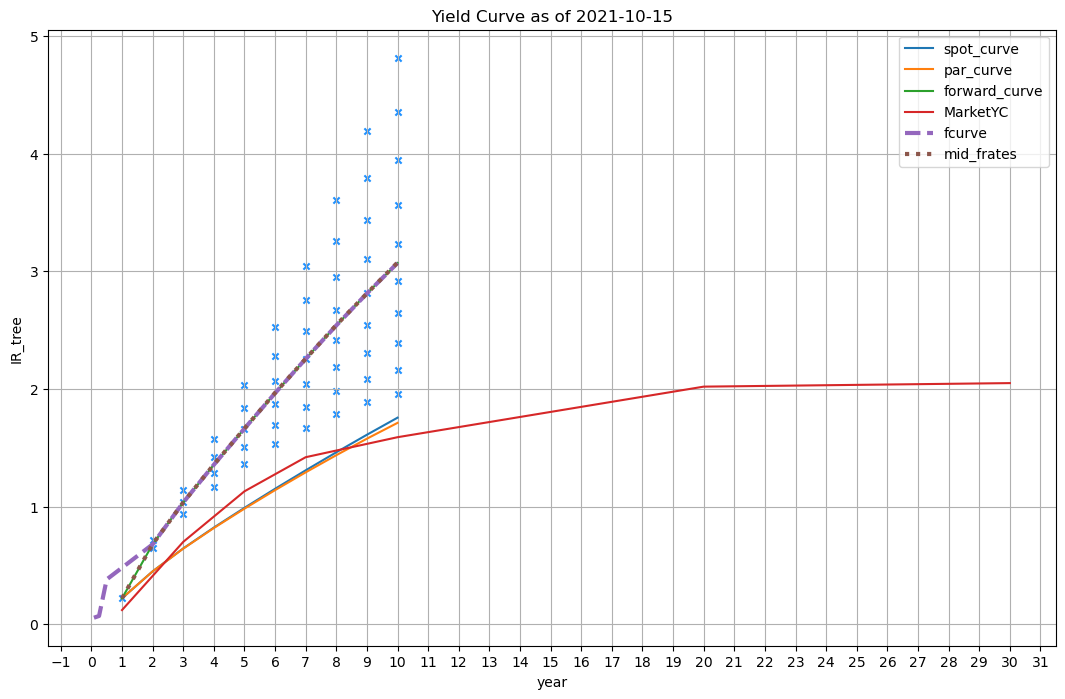

In [684]:
# plot yield curve
df_ = pd.concat([YC[['spot_curve','par_curve','forward_curve']],marketYC,f_curve], axis=1)

fig,ax = plt.subplots(figsize=(13,8), dpi=100)
# Term structure of interest rate
YC[['spot_curve','par_curve','forward_curve']].plot(ax=ax)
# market yield
marketYC.plot(ax=ax)
# includes forward rates on money market securities

# generate binomial IR tree
fcurve = YC['forward_curve']
IR_tree = generate_IR_tree(fcurve, maturity, IR_vol = 0.05)

# check mid forward rates of the IR tree
mid_frates = calculate_mid_frates(IR_tree)

f_curve.plot(ax=ax, linestyle='--', linewidth=3)
ax.set_ylabel('rates(%)')
ax.set_title(f'Yield Curve as of {date}')
IR_tree.plot(kind='scatter',x='year',y='IR_tree', ax=ax, marker='x', c='dodgerblue', s=20)
mid_frates.plot(ax=ax, linestyle=':', linewidth=3)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.grid()

# Interest Boostrapping
To check if we still get the same spot rate that we began with. Using the par curve, we can reverse engineer and get back the spot rates.

In [685]:
# Interest rate bootstrapping (deriving spot curve from par curve)

for year in YC.year:
    if year == 1:
        # set up the same starting point of bootstrapped spot curve and DF as the par curve in Year 1
        YC['bootstrapped_spot_curve'] = (100*(1+YC.par_curve[1]/100) / 100 -1) * 100
        YC['bootstrapped_spot_DF'] = 1/(1+YC.par_curve[1]/100)
    elif year > 1:
        # spot rate bootstrapping process after Year 1
        # coupon based on par curve
        coupon = 100 * YC.par_curve[year]/100
        
        # discount factors using the past bootstrapped spot rates until period t-1
        prev_bootstrapped_DFs = YC['bootstrapped_spot_DF'][:year-1]
        
        # boostrapping spot rate in period t
        bootstrapped_spot_rate = 100 * (((100+coupon) / (100 - sum(coupon * prev_bootstrapped_DFs))) ** (1/year) - 1)
        
        # update period t boostrapped spot rate and discount factor
        YC.loc[year,'bootstrapped_spot_curve'] = bootstrapped_spot_rate
        YC.loc[year,'bootstrapped_spot_DF'] = 1/(1+YC.bootstrapped_spot_curve[year]/100) ** year

In [686]:
# bootstrapping sanity check:
YC[['spot_curve','bootstrapped_spot_curve']]

,spot_curve,bootstrapped_spot_curve
year,,
1,0.2204,0.2204
2,0.4494,0.4494
3,0.6443,0.6443
4,0.8217,0.8217
5,0.9895,0.9895
6,1.1514,1.1514
7,1.3086,1.3086
8,1.4618,1.4618
9,1.6110,1.6110


In [687]:
# bootstrapping sanity check:
YC[['spot_DF','bootstrapped_spot_DF']]

,spot_DF,bootstrapped_spot_DF
year,,
1,0.997801,0.997801
2,0.991072,0.991072
3,0.980917,0.980917
4,0.967796,0.967796
5,0.951960,0.951960
6,0.933617,0.933617
7,0.913011,0.913011
8,0.890388,0.890388
9,0.866031,0.866031


### Multi-period forward rates

In [688]:
floan_beg = 2
floan_end = 10
floan_period = floan_end - floan_beg

# calculate forward rate 'F2x10'
data = get_frates(data, floan_beg, floan_end)

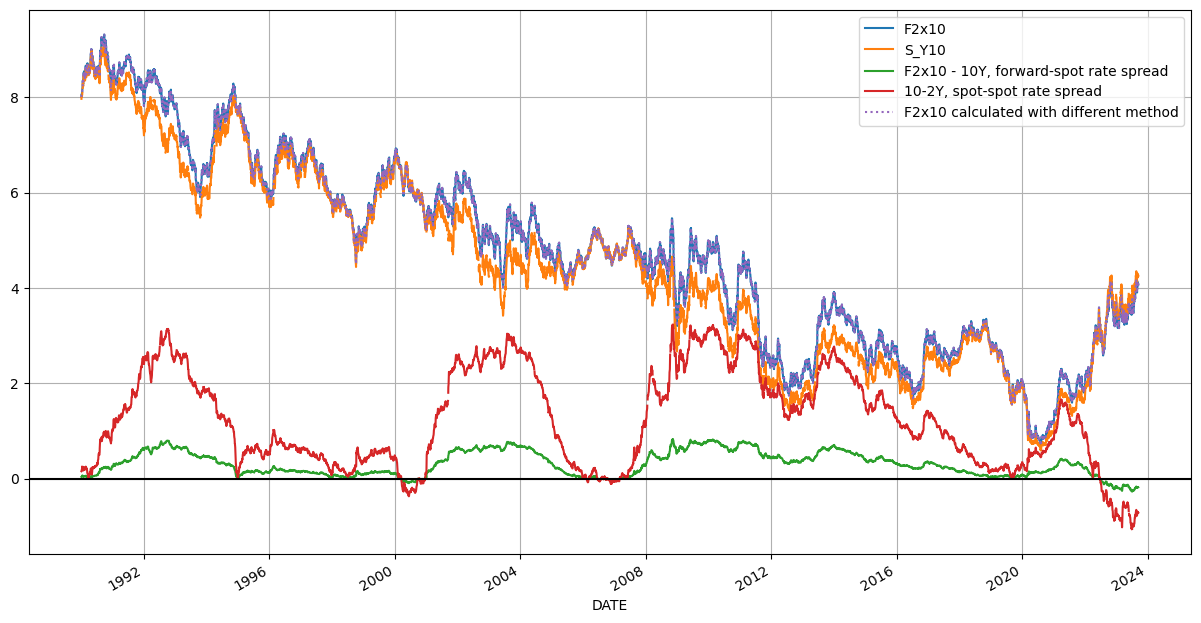

In [689]:
fig, ax = plt.subplots(figsize=(15,8))
data['F2x10'].dropna().plot(ax=ax)
data['S_Y10'].plot(ax=ax)
(data['F2x10'] - data['S_Y10']).plot(ax=ax, label='F2x10 - 10Y, forward-spot rate spread')
(data['S_Y10'] - data['S_Y2']).plot(ax=ax, label='10-2Y, spot-spot rate spread')
ax.axhline(0,c='black')

# also calculated by accumulating one-period forward rates during the forward rate period
diff_method_F2x10 = 100 * (
    (1+data[['F2x3','F3x4','F4x5','F5x6','F6x7','F7x8','F8x9','F9x10']].dropna()/100).product(axis=1) ** (1/floan_period) - 1
)
diff_method_F2x10.plot(ax=ax, linestyle=':', label='F2x10 calculated with different method')
ax.legend()
ax.grid();

9.75 years underlying forward loan


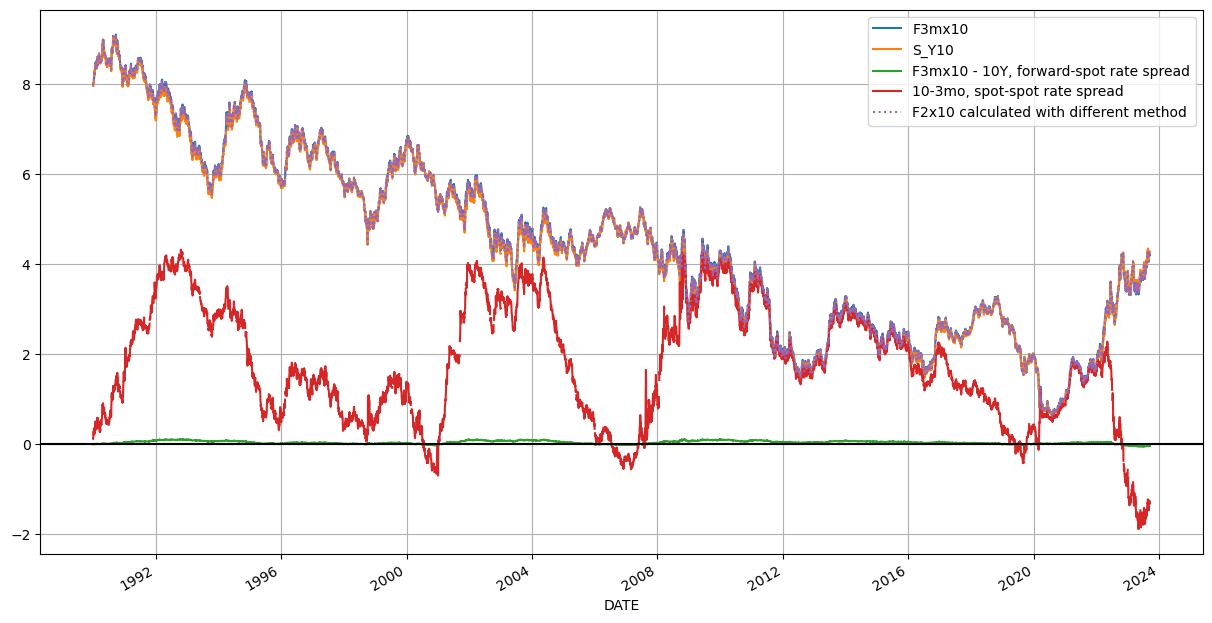

In [690]:
floan_beg = 3  # 3mo
floan_end = 10 # 10Y
floan_period = floan_end - floan_beg/12
print(floan_period, 'years underlying forward loan')
longer_loan_rate = (1 + data[f'S_Y{floan_end}']/100) ** floan_end
shorter_loan_rate = (1 + data[f'S_{floan_beg}mo']/100) ** (floan_beg/12)
data[f'F{floan_beg}mx{floan_end}']  = 100 * ((longer_loan_rate / shorter_loan_rate) ** (1/floan_period) -1)

diff_method_F3mx10 = 100 * (
     (((1+data[['F3mx6m_comp','F6mx12m_comp']].dropna()/100) ** ([3/12, 6/12])).product(axis=1) \
     * (1+data[['F1x2','F2x3','F3x4','F4x5','F5x6','F6x7','F7x8','F8x9','F9x10']].dropna()/100).product(axis=1)) ** (1/floan_period) -1
)

fig, ax = plt.subplots(figsize=(15,8))
data['F3mx10'].dropna().plot(ax=ax)
data['S_Y10'].plot(ax=ax)
(data['F3mx10'].dropna() - data['S_Y10']).plot(ax=ax, label='F3mx10 - 10Y, forward-spot rate spread')
(data['S_Y10'] - data['S_3mo'].dropna()).plot(ax=ax, label='10-3mo, spot-spot rate spread')
ax.axhline(0,c='black')

diff_method_F3mx10.plot(ax=ax, linestyle=':', label='F2x10 calculated with different method')
ax.legend()
ax.grid();

# 3-mo sport rate is very low compared to 10Y spot rate, making its forward rate move much closer to 10Y spot rate

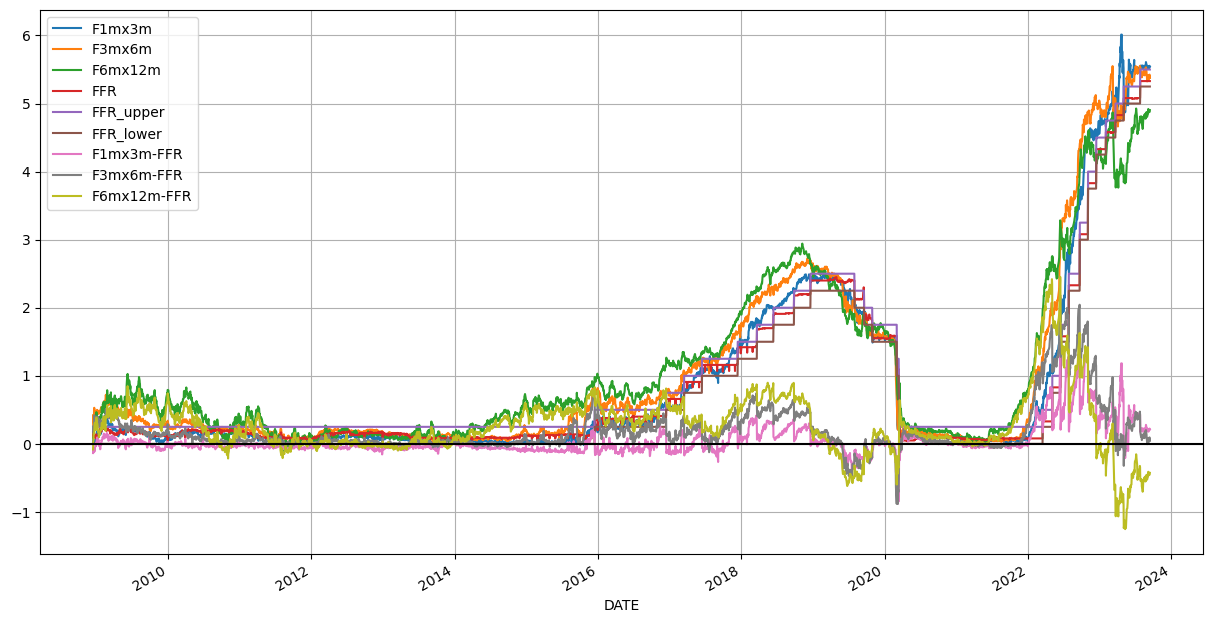

In [691]:
fig, ax = plt.subplots(figsize=(15,8))

df_ = pd.concat([data[['F1mx3m','F3mx6m','F6mx12m']],other_rates], axis=1).dropna()
df_[['F1mx3m','F3mx6m','F6mx12m']].plot(ax=ax)
df_[Fed_funds_rate.values()].dropna().plot(ax=ax)
spreads = df_[['F1mx3m','F3mx6m','F6mx12m']].sub(df_.FFR, axis=0).set_axis(['F1mx3m-FFR','F3mx6m-FFR','F6mx12m-FFR'], axis=1)
spreads.plot(ax=ax)
ax.axhline(0,c='black')
ax.legend()
ax.grid();

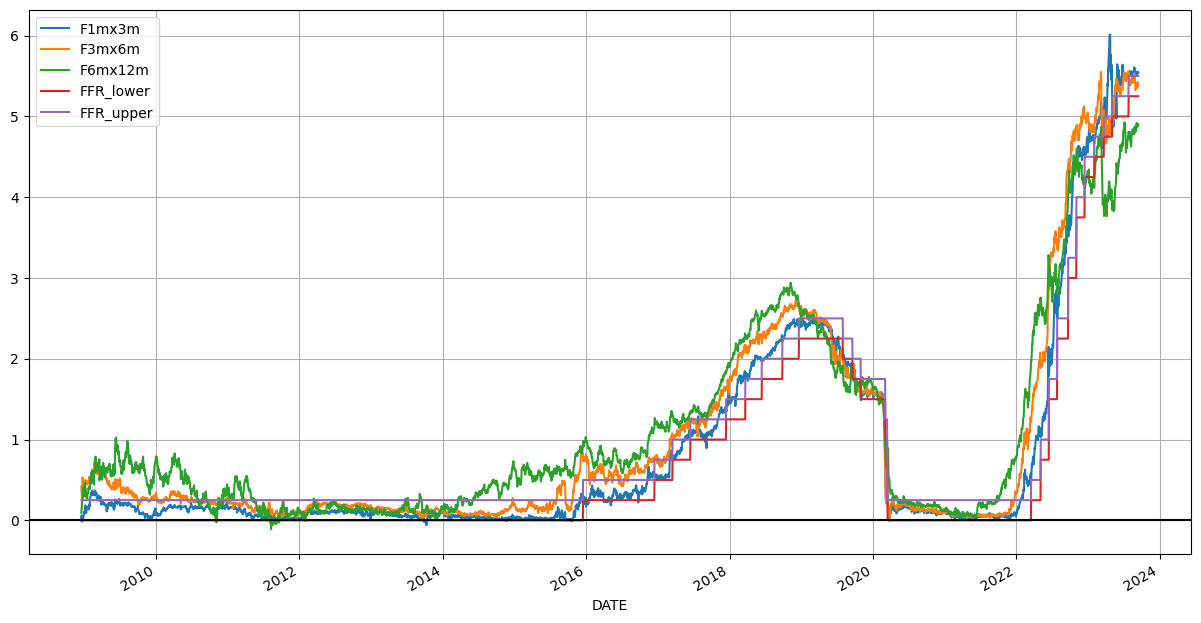

In [692]:
fig, ax = plt.subplots(figsize=(15,8))

df_ = pd.concat([data[['F1mx3m','F3mx6m','F6mx12m']],other_rates], axis=1).dropna()
df_[['F1mx3m','F3mx6m','F6mx12m']].plot(ax=ax)
df_[['FFR_lower','FFR_upper']].dropna().plot(ax=ax)

ax.axhline(0,c='black')
ax.legend()
ax.grid();

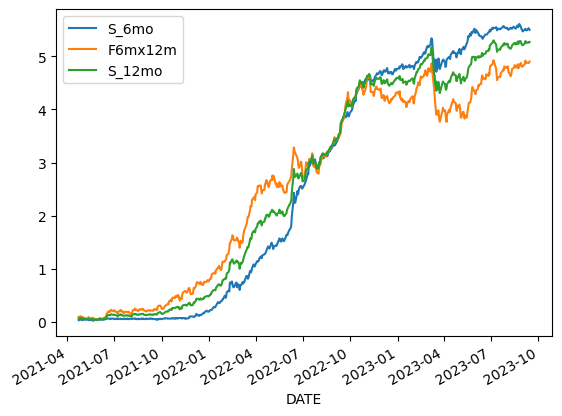

In [693]:
# forward rates are simply geometric mean of its component spot rates
data[['S_6mo', 'F6mx12m','S_12mo']].dropna().tail(600).plot();